This notebook takes ~17 minutes to run.

In [1]:
import numpy as np
import pandas as pd
import re
import ast
from sklearn.preprocessing import MultiLabelBinarizer

df = pd.read_parquet("./../data/steam_game_dataset.parquet")


# 1. Clean feature names
df.columns = (
    df.columns.str.lower()
              .str.replace(r'[^0-9a-z]+', '_', regex=True)
              .str.strip('_')
)


# 2. convert datetime
date_series = pd.to_datetime(
    df["release_date"],
    format="%b %d, %Y",   # Mon d, yyyy (e.g. Jan 3, 2024)
    errors="coerce"       # invalid formats → NaT
)
temp = df.loc[date_series.isnull(),"release_date"]
temp2 = pd.to_datetime(
    temp,
    format="%b %Y",   # Jan 2024
    errors="coerce"       # invalid formats → NaT
)
date_series.loc[date_series.isnull()] = temp2
df["release_date"] = date_series

# 3. convert estimated_owners to numeric
df["estimated_owners"] = df["estimated_owners"].replace({
    '0 - 0': 0, 
    '0 - 20000': 10000,
    '20000 - 50000': 35000,
    '50000 - 100000': 75000,
    '100000 - 200000': 150000,
    '200000 - 500000': 350000,
    '500000 - 1000000': 750000,
    '1000000 - 2000000': 1500000,
    '2000000 - 5000000': 3500000,
    '5000000 - 10000000': 7500000,
    '10000000 - 20000000': 15000000,
    '20000000 - 50000000': 35000000,
    '50000000 - 100000000': 75000000,
    '100000000 - 200000000': 150000000
}).astype("int64")

# 4. convert multi categories
def split_comma_list(s):
    if s is None:
        lst = []
    else:
        lst = [x.strip() for x in s.split(",")]
    return tuple(lst)
def split_list_comma_list(s):
    if s is None:
        lst = []
    else:
        bad = "K'iche'"
        fixed = "'K\\'iche\\''"
        if bad in s:
            s = s.replace(bad, fixed)
        bad = "'English,German,Spanish - Spain,#lang_français'"
        fixed = "'English','German','Spanish - Spain','French'"
        if bad in s:
            s = s.replace(bad, fixed)
        bad = "'Russian\\r\\nEnglish\\r\\nSpanish - Spain\\r\\nFrench\\r\\nJapanese\\r\\nCzech'"
        fixed = "'Russian','English','Spanish - Spain','French','Japanese','Czech'"
        if bad in s:
            s = s.replace(bad, fixed)
        bad = "'Hungarian,Polish'"
        fixed = "'Hungarian','Polish'"
        if bad in s:
            s = s.replace(bad, fixed)
        bad = "'English\\r\\nRussian\\r\\nSpanish - Spain\\r\\nJapanese\\r\\nCzech'"
        fixed = "'English','Russian','Spanish - Spain','Japanese','Czech'"
        if bad in s:
            s = s.replace(bad, fixed)
        lst = ast.literal_eval(s.strip())
    return tuple(lst)
df["categories"] = df["categories"].apply(split_comma_list)
df["genres"] = df["genres"].apply(split_comma_list)
df["tags"] = df["tags"].apply(split_comma_list)
df["full_audio_languages"] = df["full_audio_languages"].apply(split_list_comma_list)
df["supported_languages"] = df["supported_languages"].apply(split_list_comma_list)



C:\Users\yvnyl\AppData\Local\Temp\ipykernel_37108\1507597755.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["estimated_owners"] = df["estimated_owners"].replace({


In [2]:
pd.set_option('display.max_columns', None)

def my_summarize_df(df):
    dfd = df.describe()
    summary = pd.DataFrame({
        "SUM_dtype": df.dtypes,
        "SUM_n_not_na": df.notna().sum(),
        "SUM_pct_null": df.isnull().mean(),
        "SUM_n_nonzero": (df!=0).sum(),
        "SUM_n_unique": df.nunique(),
        "DES_mean": dfd.loc["mean"].T,
        "DES_median": dfd.loc["50%"].T,
        "DES_min": dfd.loc["min"].T,
        "DES_max": dfd.loc["max"].T,
    }).T
    thresh = df.shape[1]
    while df.dropna(thresh=thresh).head(3).shape[0]<3:
        thresh = thresh - 1
    summary = pd.concat([summary, df.dropna(thresh=thresh).head(3)], axis=0)
    return summary

summary = my_summarize_df(df)
summary

about_the_game achievements  \
SUM_dtype                                                 object        int64   
SUM_n_not_na                                               80123        83560   
SUM_pct_null                                            0.041132          0.0   
SUM_n_nonzero                                              83560        41209   
SUM_n_unique                                               79697          431   
DES_mean                                                     NaN    20.083772   
DES_median                                                   NaN          0.0   
DES_min                                                      NaN          0.0   
DES_max                                                      NaN       9821.0   
470            Phoenix Point is the acclaimed strategy game f...           47   
923            Overview As a hospital coordinator, Ga-yeon fe...           36   
1622           Tales of real stories Welcome to Elk, an adven...           25   

                       appid average_playtime_forever  \
SUM_dtype              int64                    int64   
SUM_n_not_na           83560                    83560   
SUM_pct_null             0.0                      0.0   
SUM_n_nonzero          83560                    14904   
SUM_n_unique           83560                     2209   
DES_mean       1334063.22591               106.641204   
DES_median         1304165.0                      0.0   
DES_min                 10.0                      0.0   
DES_max            2719700.0                 145727.0   
470                   839770                      426   
923                   371120                      481   
1622                 1015940                        0   

              average_playtime_two_weeks  \
SUM_dtype                          int64   
SUM_n_not_na                       83560   
SUM_pct_null                         0.0   
SUM_n_nonzero                       2048   
SUM_n_unique                         779   
DES_mean                       10.854931   
DES_median                           0.0   
DES_min                              0.0   
DES_max                          19159.0   
470                                    0   
923                                    0   
1622                                   0   

                                                      categories  \
SUM_dtype                                                 object   
SUM_n_not_na                                               83560   
SUM_pct_null                                                 0.0   
SUM_n_nonzero                                              83560   
SUM_n_unique                                                5622   
DES_mean                                                     NaN   
DES_median                                                   NaN   
DES_min                                                      NaN   
DES_max                                                      NaN   
470            (Single-player, Steam Achievements, Full contr...   
923            (Single-player, Steam Achievements, Full contr...   
1622           (Single-player, Steam Achievements, Full contr...   

                        developers dlc_count estimated_owners  \
SUM_dtype                   object     int64            int64   
SUM_n_not_na                 80103     83560            83560   
SUM_pct_null              0.041371       0.0              0.0   
SUM_n_nonzero                83560     11762            72793   
SUM_n_unique                 48989        95               14   
DES_mean                       NaN  0.551795     87264.719962   
DES_median                     NaN       0.0          10000.0   
DES_min                        NaN       0.0              0.0   
DES_max                        NaN    2366.0      150000000.0   
470            Snapshot Games Inc.         7           350000   
923               YGGDRASIL STUDIO         8            10000   
1622            

# Numerical columns
There are 15 numerical columns. Let's look at the distributions.

Plotting as is (not shown), we can only see huge spikes at 0 for most of them. Even after log-transform (not shown), it is still hard to see anything because of the huge 0 spike.

Linear models would also have problems with the dominance of zeros.

Plotting the log-transform of only positive values looks the best (see figure).

The final solution is, for each numerical column, 
1. generate a boolean feature that indicates if the value is zero,
2. log-transform to correct for skewness.

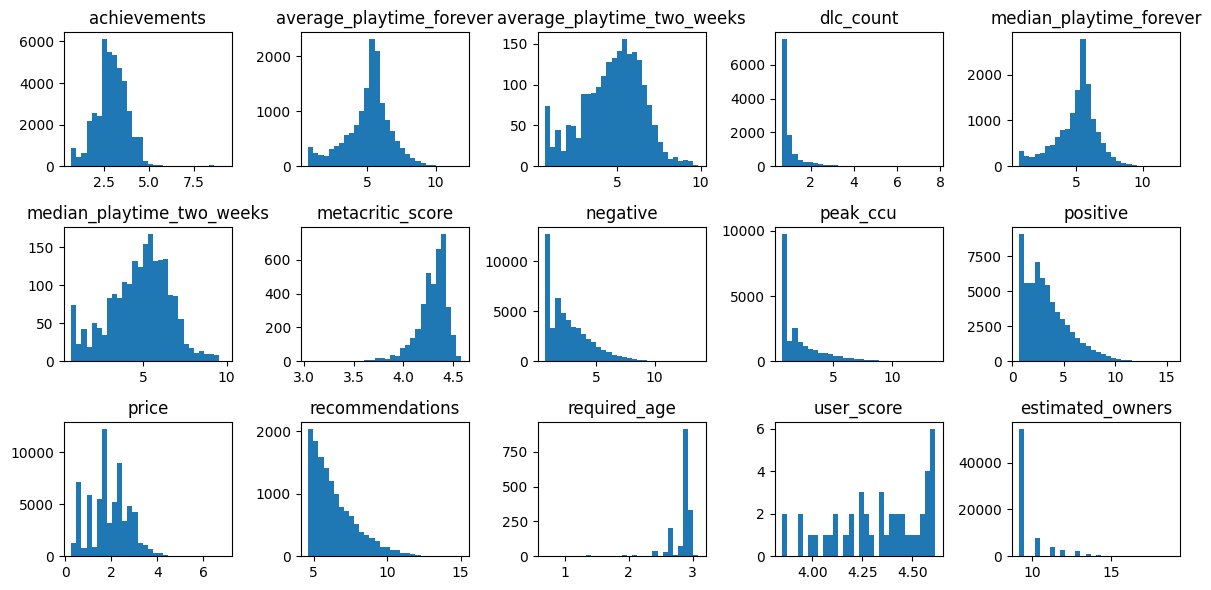

In [3]:
num_cols = ["achievements", 
    "average_playtime_forever", 
    "average_playtime_two_weeks", 
    "dlc_count",
    "median_playtime_forever",
    "median_playtime_two_weeks",
    "metacritic_score",
    "negative",
    "peak_ccu",
    "positive",
    "price",
    "recommendations",
    "required_age",
    "user_score",
    "estimated_owners"]

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 6))
axes = axes.flatten()

for i in range(len(num_cols)):
    # axes[i].hist(df[num_cols[i]].dropna(), bins=30) # all not null
    # axes[i].hist(df.loc[df[num_cols[i]]>0,num_cols[i]], bins=30) # all positive
    # axes[i].hist(np.log1p(df[num_cols[i]].dropna()), bins=30) # log1p all not null
    axes[i].hist(np.log1p(df.loc[df[num_cols[i]]>0,num_cols[i]]), bins=30) # log1p all positive
    axes[i].set_title(f"{num_cols[i]}")

plt.tight_layout()
plt.show()

In [4]:
# make X based on numeric columns
num_cols.remove('metacritic_score') # remove Y

df_X_num = pd.DataFrame()
for i in range(len(num_cols)):
    df_X_num[f"{num_cols[i]}_is0"] = df[num_cols[i]].eq(0).where(df[num_cols[i]].notna())
    df_X_num[f"{num_cols[i]}_log1p"] = np.log1p(df[num_cols[i]])

summary = my_summarize_df(df_X_num)
summary

achievements_is0 achievements_log1p  \
SUM_dtype                 bool            float64   
SUM_n_not_na             83560              83560   
SUM_pct_null               0.0                0.0   
SUM_n_nonzero            42351              41209   
SUM_n_unique                 2                431   
DES_mean                   NaN           1.461526   
DES_median                 NaN                0.0   
DES_min                    NaN                0.0   
DES_max                    NaN            9.19238   
0                        False           3.433987   
1                        False           2.564949   
2                         True                0.0   

              average_playtime_forever_is0 average_playtime_forever_log1p  \
SUM_dtype                             bool                        float64   
SUM_n_not_na                         83560                          83560   
SUM_pct_null                           0.0                            0.0   
SUM_n_nonzero                        68656                          14904   
SUM_n_unique                             2                           2209   
DES_mean                               NaN                       0.909818   
DES_median                             NaN                            0.0   
DES_min                                NaN                            0.0   
DES_max                                NaN                      11.889497   
0                                     True                            0.0   
1                                     True                            0.0   
2                                     True                            0.0   

              average_playtime_two_weeks_is0 average_playtime_two_weeks_log1p  \
SUM_dtype                               bool                          float64   
SUM_n_not_na                           83560                            83560   
SUM_pct_null                             0.0                              0.0   
SUM_n_nonzero                          81512                             2048   
SUM_n_unique                               2                              779   
DES_mean                                 NaN                         0.116549   
DES_median                               NaN                              0.0   
DES_min                                  NaN                              0.0   
DES_max                                  NaN                          9.86058   
0                                       True                              0.0   
1                                       True                              0.0   
2                                       True                              0.0   

              dlc_count_is0 dlc_count_log1p estimated_owners_is0  \
SUM_dtype              bool         float64                 bool   
SUM_n_not_na          83560           83560                83560   
SUM_pct_null            0.0             0.0                  0.0   
SUM_n_nonzero         71798           11762                10767   
SUM_n_unique              2              95                    2   
DES_mean                NaN        0.144002                  NaN   
DES_median              NaN             0.0                  NaN   
DES_min                 NaN             0.0                  NaN   
DES_max                 NaN        7.769379                  NaN   
0                      True             0.0                False   
1                      True             0.0                False   
2                      True             0.0                False   

              estimated_owners_log1p median_playtime_forever_is0  \
SUM_dtype                    float64                        bool   
SUM_n_not_na                   83560                       83560   
SUM_pct_null                     0.0                         0.0   
SUM_n_nonzero                  72793                       68656   
SUM_n_unique                      14       

# Date
Needs to be converted to numeric: days since epoch

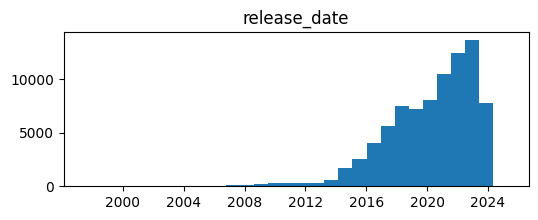

In [5]:
plt.figure(figsize=(6, 2))
plt.hist(df["release_date"], bins=30)
plt.title("release_date")
plt.show()

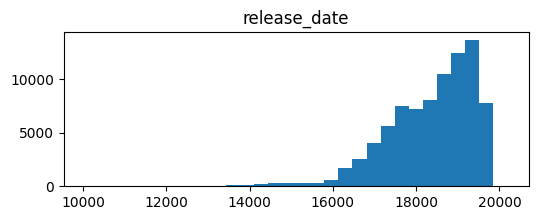

In [6]:
epoch = pd.Timestamp("1970-01-01")
df["release_date"] = (pd.to_datetime(df["release_date"]) - epoch).dt.days
plt.figure(figsize=(6, 2))
plt.hist(df["release_date"], bins=30)
plt.title("release_date")
plt.show()

# Tags and languages

In [7]:
print(df["categories"].explode().nunique())
print(df["categories"].explode().value_counts().index.tolist())

41
['Single-player', 'Steam Achievements', 'Steam Cloud', 'Full controller support', 'Multi-player', 'Partial Controller Support', 'Steam Trading Cards', 'PvP', 'Co-op', 'Online PvP', 'Steam Leaderboards', 'Remote Play Together', 'Shared/Split Screen', 'Online Co-op', 'Shared/Split Screen PvP', 'Stats', 'Shared/Split Screen Co-op', 'Cross-Platform Multiplayer', 'In-App Purchases', 'Remote Play on TV', 'Includes level editor', 'Steam Workshop', 'MMO', 'Captions available', 'Remote Play on Tablet', 'Remote Play on Phone', 'LAN PvP', 'VR Only', 'LAN Co-op', 'Tracked Controller Support', 'VR Support', 'Commentary available', 'Valve Anti-Cheat enabled', 'VR Supported', 'Steam Turn Notifications', 'Includes Source SDK', 'SteamVR Collectibles', 'HDR available', 'Mods (require HL2)', 'Mods', 'Tracked Motion Controller Support']


In [8]:
print(df["full_audio_languages"].explode().nunique())
print(df["full_audio_languages"].explode().value_counts().index.tolist())

121
['English', 'Simplified Chinese', 'Russian', 'Japanese', 'German', 'French', 'Spanish - Spain', 'Traditional Chinese', 'Italian', 'Portuguese - Brazil', 'Korean', 'Polish', 'Turkish', 'Spanish - Latin America', 'Dutch', 'Ukrainian', 'Swedish', 'Czech', 'Arabic', 'Hungarian', 'Thai', 'Danish', 'Portuguese', 'Finnish', 'Norwegian', 'Vietnamese', 'Greek', 'Romanian', 'Bulgarian', 'Portuguese - Portugal', 'Indonesian', 'Hindi', 'Zulu', 'Malay', 'Serbian', 'Catalan', 'Slovak', 'Latvian', 'Bangla', 'Hebrew', 'Azerbaijani', 'Georgian', 'Urdu', 'Bosnian', 'Albanian', 'Lithuanian', 'Uzbek', 'Croatian', 'Slovenian', 'Galician', 'Belarusian', 'Estonian', 'Persian', 'Filipino', 'Igbo', 'Afrikaans', 'Macedonian', 'Icelandic', 'Punjabi (Gurmukhi)', 'Mongolian', 'Tamil', 'Basque', 'Kazakh', 'Irish', 'Telugu', 'Yoruba', 'Uyghur', 'Xhosa', 'Welsh', 'Tajik', 'Kinyarwanda', 'Sinhala', 'Punjabi (Shahmukhi)', 'Tatar', 'Swahili', 'Turkmen', 'Amharic', 'Sotho', 'Malayalam', 'Marathi', 'Odia', 'Kyrgyz', '

In [9]:
def clean_full_audio_languages(t):
    replacements = {
        'English&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'English',
        'French&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'French',
        'Italian&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Italian',
        'German&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'German',
        'Spanish - Spain&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Spanish - Spain',
        'Korean&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Korean',
        'Japanese &amp;lt;br /&amp;gt;&amp;lt;br /&amp;gt;&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt; ': 'Japanese',
        'English[b][/b]': 'English', 
        'French[b][/b]': 'French', 
        'Italian[b][/b]': 'Italian',
        'German[b][/b]': 'German', 
        'Spanish - Spain[b][/b]': 'Spanish - Spain', 
        'Korean[b][/b]': 'Korean',
        'Japanese \r\n\r\n[b][/b] ': 'Japanese', 
        'Italian \r\n\r\n[b][/b] ': 'Italian',
        'Russian\r\n[b][/b]': 'Russian', 
        'Spanish - Spain\r\n[b][/b]': 'Spanish - Spain',
    }
    new_t = tuple(replacements.get(x, x) for x in t)
    return new_t
df["full_audio_languages_clean"] = df["full_audio_languages"].apply(clean_full_audio_languages)

In [10]:
print(df["full_audio_languages_clean"].explode().nunique())
print(df["full_audio_languages_clean"].explode().value_counts().index.tolist())

104
['English', 'Simplified Chinese', 'Russian', 'Japanese', 'German', 'French', 'Spanish - Spain', 'Traditional Chinese', 'Italian', 'Portuguese - Brazil', 'Korean', 'Polish', 'Turkish', 'Spanish - Latin America', 'Dutch', 'Ukrainian', 'Swedish', 'Czech', 'Arabic', 'Hungarian', 'Thai', 'Danish', 'Portuguese', 'Finnish', 'Norwegian', 'Vietnamese', 'Greek', 'Romanian', 'Bulgarian', 'Portuguese - Portugal', 'Indonesian', 'Hindi', 'Zulu', 'Malay', 'Catalan', 'Serbian', 'Slovak', 'Latvian', 'Bangla', 'Hebrew', 'Azerbaijani', 'Georgian', 'Urdu', 'Lithuanian', 'Bosnian', 'Albanian', 'Uzbek', 'Croatian', 'Slovenian', 'Estonian', 'Persian', 'Galician', 'Filipino', 'Belarusian', 'Afrikaans', 'Igbo', 'Macedonian', 'Icelandic', 'Mongolian', 'Basque', 'Punjabi (Gurmukhi)', 'Kazakh', 'Irish', 'Tamil', 'Yoruba', 'Uyghur', 'Amharic', 'Gujarati', 'Nepali', 'Kannada', 'Hausa', 'Armenian', 'Tatar', 'Swahili', 'Xhosa', 'Telugu', 'Sotho', 'Malayalam', 'Marathi', 'Odia', 'Kyrgyz', 'Luxembourgish', 'Maltese

In [11]:
print(df["genres"].explode().nunique())
print(df["genres"].explode().value_counts().index.tolist())

33
['Indie', 'Casual', 'Action', 'Adventure', 'Simulation', 'Strategy', 'RPG', 'Early Access', 'Free to Play', 'Sports', 'Racing', 'Massively Multiplayer', 'Utilities', 'Violent', 'Design & Illustration', 'Animation & Modeling', 'Education', 'Gore', 'Video Production', 'Game Development', 'Software Training', 'Audio Production', 'Photo Editing', 'Nudity', 'Web Publishing', 'Sexual Content', 'Accounting', 'Movie', 'Documentary', 'Episodic', 'Short', 'Tutorial', '360 Video']


In [12]:
print(df["supported_languages"].explode().nunique())
print(df["supported_languages"].explode().value_counts().index.tolist())

130
['English', 'Simplified Chinese', 'German', 'French', 'Russian', 'Spanish - Spain', 'Japanese', 'Italian', 'Korean', 'Traditional Chinese', 'Portuguese - Brazil', 'Polish', 'Turkish', 'Dutch', 'Spanish - Latin America', 'Portuguese', 'Czech', 'Swedish', 'Ukrainian', 'Hungarian', 'Thai', 'Arabic', 'Danish', 'Norwegian', 'Finnish', 'Romanian', 'Greek', 'Vietnamese', 'Bulgarian', 'Portuguese - Portugal', 'Indonesian', 'Hindi', 'Catalan', 'Malay', 'Slovak', 'Serbian', 'Hebrew', 'Latvian', 'Bangla', 'Basque', 'Lithuanian', 'Croatian', 'Estonian', 'Filipino', 'Belarusian', 'Azerbaijani', 'Albanian', 'Persian', 'Galician', 'Afrikaans', 'Bosnian', 'Urdu', 'Georgian', 'Icelandic', 'Slovenian', 'Irish', 'Macedonian', 'Kazakh', 'Uzbek', 'Mongolian', 'Luxembourgish', 'Welsh', 'Zulu', 'Swahili', 'Malayalam', 'Tajik', 'Tatar', 'Tamil', 'Kinyarwanda', 'Yoruba', 'Hausa', 'Turkmen', 'Uyghur', 'Armenian', 'Maltese', 'Nepali', 'Punjabi (Gurmukhi)', 'Sotho', 'Kyrgyz', 'Gujarati', 'Kannada', 'Igbo', 'S

In [13]:
def clean_supported_languages(t):
    replacements = {
        '\r\nFrench': 'French',
        '\r\nGerman': 'German',
        'German;': 'German',
        'English&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'English',
        'French&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'French',
        'Italian&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Italian',
        'German&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'German',
        'Spanish - Spain&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Spanish - Spain',
        'Korean&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt;': 'Korean',
        'Japanese &amp;lt;br /&amp;gt;&amp;lt;br /&amp;gt;&amp;lt;strong&amp;gt;&amp;lt;/strong&amp;gt; ': 'Japanese',
        'Traditional Chinese (text only)': 'Traditional Chinese',
        'English[b][/b]': 'English',
        'French[b][/b]': 'French',
        'Italian[b][/b]': 'Italian',
        'German[b][/b]': 'German',
        'Spanish - Spain[b][/b]': 'Spanish - Spain',
        'Korean[b][/b]': 'Korean',
        'Japanese \r\n\r\n[b][/b] ': 'Japanese',
        'Italian \r\n\r\n[b][/b] ': 'Italian',
        'English (full audio)': 'English',
        'Russian\r\n[b][/b]': 'Russian',
        'Spanish - Spain\r\n[b][/b]': 'Spanish - Spain',
        ' Korean': 'Korean',
        'Japanese (all with full audio support)': 'Japanese'
    }
    new_t = tuple(replacements.get(x, x) for x in t)
    return new_t
df["supported_languages_clean"] = df["supported_languages"].apply(clean_supported_languages)

In [14]:
print(df["supported_languages_clean"].explode().nunique())
print(df["supported_languages_clean"].explode().value_counts().index.tolist())

106
['English', 'Simplified Chinese', 'German', 'French', 'Russian', 'Spanish - Spain', 'Japanese', 'Italian', 'Korean', 'Traditional Chinese', 'Portuguese - Brazil', 'Polish', 'Turkish', 'Dutch', 'Spanish - Latin America', 'Portuguese', 'Czech', 'Swedish', 'Ukrainian', 'Hungarian', 'Thai', 'Arabic', 'Danish', 'Norwegian', 'Finnish', 'Romanian', 'Greek', 'Vietnamese', 'Bulgarian', 'Portuguese - Portugal', 'Indonesian', 'Hindi', 'Catalan', 'Malay', 'Slovak', 'Serbian', 'Hebrew', 'Latvian', 'Basque', 'Bangla', 'Lithuanian', 'Croatian', 'Estonian', 'Filipino', 'Belarusian', 'Azerbaijani', 'Persian', 'Galician', 'Albanian', 'Bosnian', 'Urdu', 'Afrikaans', 'Icelandic', 'Georgian', 'Slovenian', 'Irish', 'Kazakh', 'Macedonian', 'Mongolian', 'Uzbek', 'Luxembourgish', 'Welsh', 'Swahili', 'Zulu', 'Tajik', 'Malayalam', 'Tatar', 'Tamil', 'Kinyarwanda', 'Yoruba', 'Hausa', 'Turkmen', 'Uyghur', 'Armenian', 'Maltese', 'Nepali', 'Punjabi (Gurmukhi)', 'Sotho', 'Kyrgyz', 'Xhosa', 'Kannada', 'Igbo', 'Scot

In [15]:
print(df["tags"].explode().nunique())
print(df["tags"].explode().value_counts().index.tolist())

448
['Indie', 'Singleplayer', 'Action', 'Casual', 'Adventure', '2D', 'Strategy', 'Simulation', 'RPG', 'Puzzle', 'Atmospheric', '3D', 'Early Access', 'Pixel Graphics', 'Story Rich', 'Colorful', 'Cute', 'Multiplayer', 'Exploration', 'Arcade', 'First-Person', 'Fantasy', 'Funny', 'Shooter', 'Retro', 'Platformer', 'Horror', 'Anime', 'Family Friendly', 'Sci-fi', 'Relaxing', 'Action-Adventure', 'Difficult', 'VR', 'Female Protagonist', 'Survival', 'Third Person', 'Open World', 'Great Soundtrack', 'Top-Down', 'Stylized', 'Comedy', 'Controller', 'Free to Play', 'Violent', 'Combat', 'FPS', 'Visual Novel', 'Co-op', '2D Platformer', 'Minimalist', 'Physics', 'Mystery', 'Point & Click', 'Cartoony', 'Dark', 'Realistic', 'Choices Matter', 'Gore', 'Psychological Horror', 'Linear', 'Sandbox', 'PvP', 'Sports', 'Space', 'Side Scroller', 'Multiple Endings', 'Rogue-like', 'Puzzle-Platformer', 'Tactical', 'Old School', 'Building', 'Management', 'Sexual Content', 'Hidden Object', 'Character Customization', 'Nu

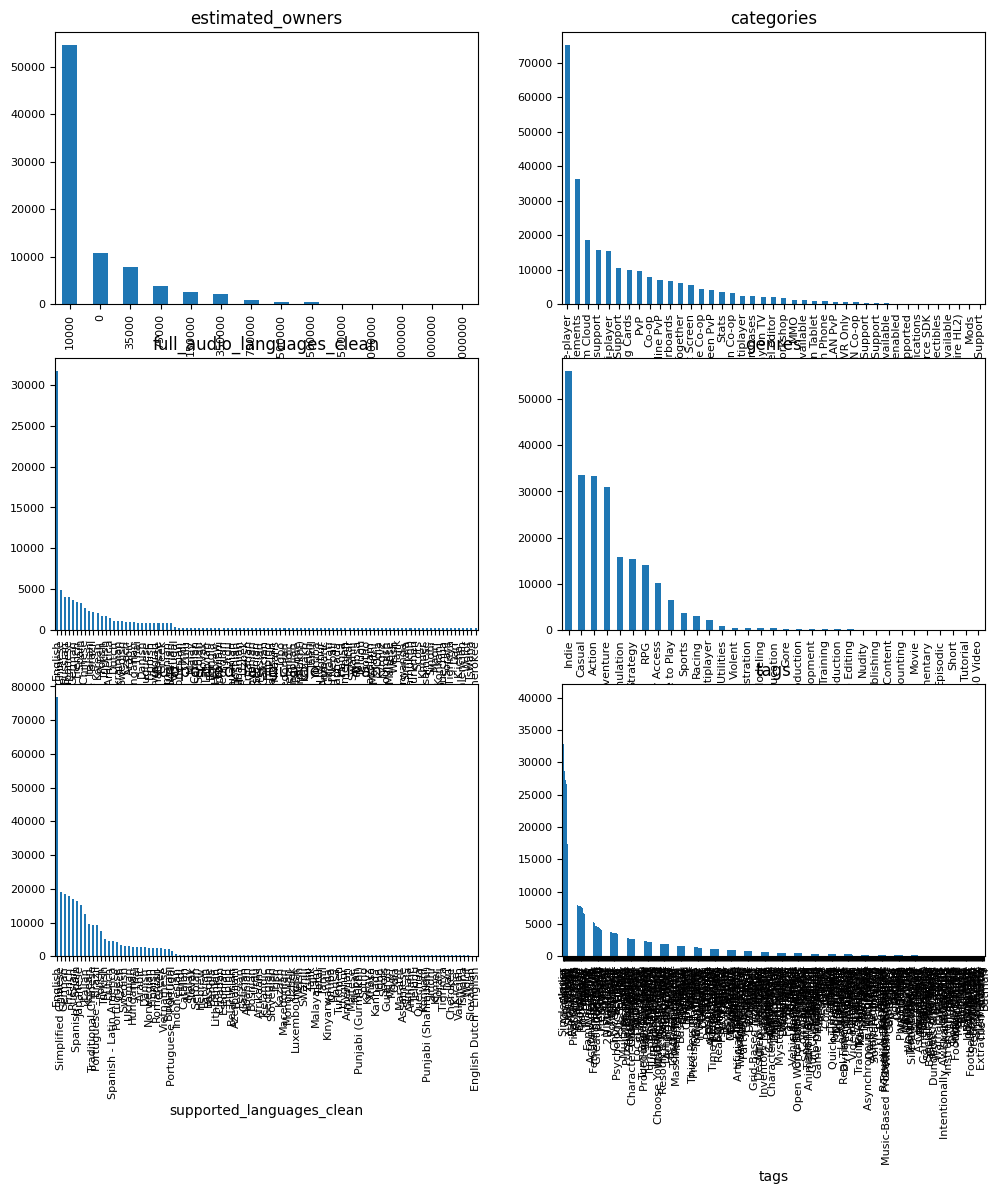

In [16]:
cat_cols = ["estimated_owners",
           "categories",
           "full_audio_languages_clean",
           "genres",
           "supported_languages_clean",
           "tags"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i in range(len(cat_cols)):
    df[cat_cols[i]].explode().value_counts().plot.bar(ax=axes[i], fontsize=8)
    axes[i].set_title(f"{cat_cols[i]}")


plt.show()

# Word cloud

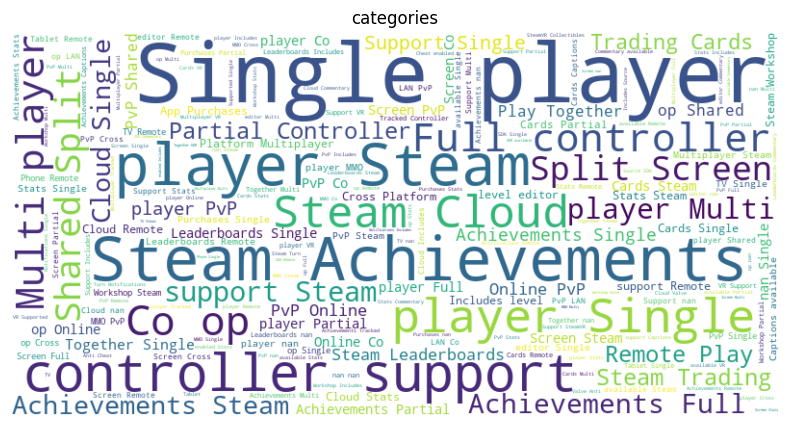

In [17]:
import re
from wordcloud import STOPWORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['categories'].explode().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("categories")
plt.show()

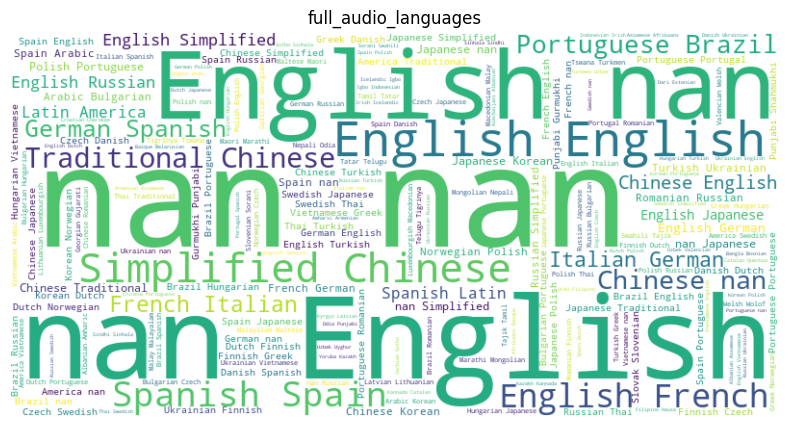

In [18]:
text = ' '.join(df['full_audio_languages'].explode().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("full_audio_languages")
plt.show()

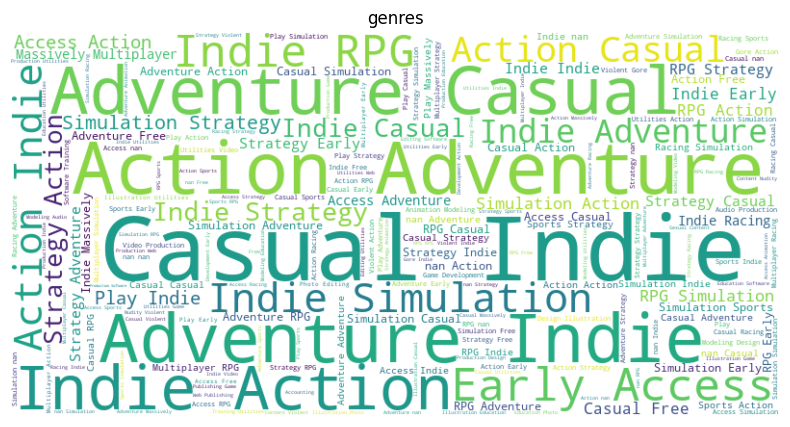

In [19]:
text = ' '.join(df['genres'].explode().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("genres")
plt.show()

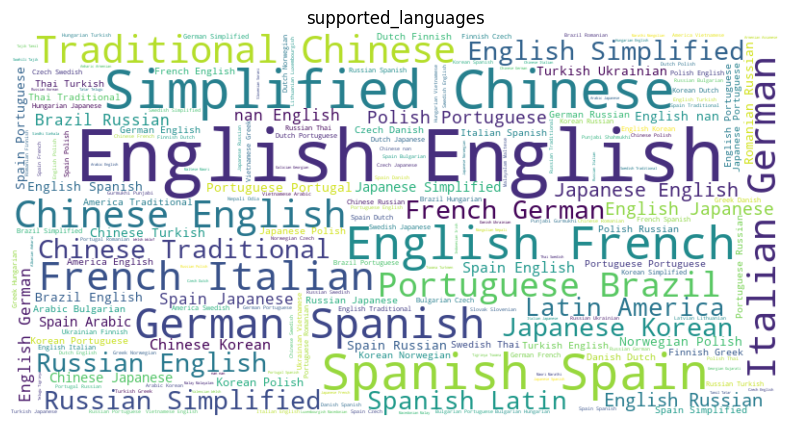

In [20]:
text = ' '.join(df['supported_languages'].explode().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("supported_languages")
plt.show()

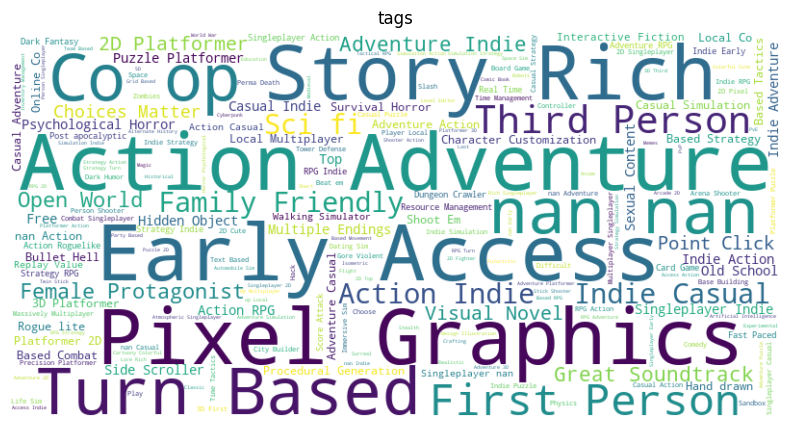

In [21]:
text = ' '.join(df['tags'].explode().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("tags")
plt.show()

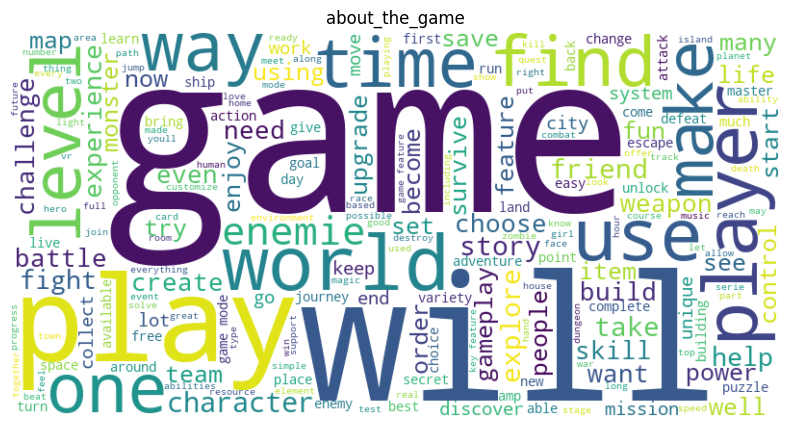

In [22]:
text = ' '.join(df['about_the_game'].astype(str).tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("about_the_game")
plt.show()

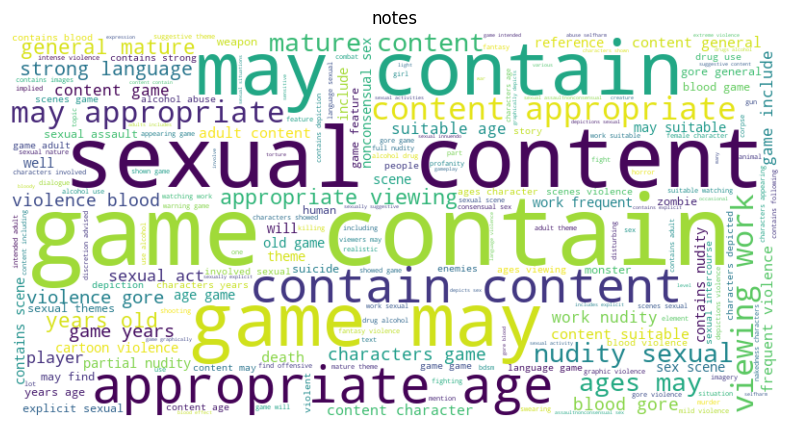

In [23]:
text = ' '.join(df['notes'].dropna().astype(str).tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("notes")
plt.show()


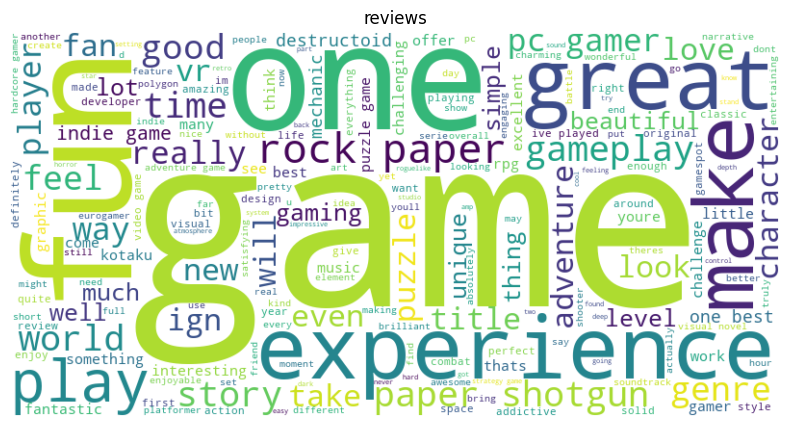

In [24]:
text = ' '.join(df['reviews'].dropna().astype(str).tolist())

text = re.sub(r'[^A-Za-z\s]', '', text)

text = text.lower()

stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("reviews")
plt.show()


# Information availability

There are several columns containing information about the game, such as "about_the_game", "support_email", and "supported_languages", that have quite a lot of missing values. The unavailability of these information could indicate the game's low budget, lack of on going support, and lack of success. Let's make features based this, i.e., is the information available (not na).

In [25]:
df_X_info_avail = pd.DataFrame({
    "support_email_notna": df["support_email"].notna(),
    "about_the_game_notna": df["about_the_game"].notna(),
    "notes_notna": df["notes"].notna(),
    "reviews_notna": df["reviews"].notna(),
    "developers_notna": df["developers"].notna(),
    "publishers_notna": df["publishers"].notna(),
    "screenshots_notna": df["screenshots"].notna(),
    "movies_notna": df["movies"].notna(),
    "support_email_notna": df["support_email"].notna(),
    "support_url_notna": df["support_url"].notna(),
    "website_notna": df["website"].notna(),
    "categories_notna": df["categories"].apply(lambda x: len(x)==0),
    "genres_notna": df["genres"].apply(lambda x: len(x)==0),
    "tags_notna": df["tags"].apply(lambda x: len(x)==0),
    "full_audio_languages_notna": df["full_audio_languages_clean"].apply(lambda x: len(x)==0),
    "supported_languages_notna": df["supported_languages_clean"].apply(lambda x: len(x)==0),
})

# Expand multi-categorical columns into multi-hot encoding

In [26]:
mlb = MultiLabelBinarizer()

In [27]:
MH_categories = mlb.fit_transform(df["categories"])
columns = [f"MH_categories_{i+1}" for i in range(MH_categories.shape[1])]
df_MH_categories = pd.DataFrame(MH_categories, columns=columns)

In [28]:
MH_full_audio_languages = mlb.fit_transform(df["full_audio_languages_clean"])
columns = [f"MH_full_audio_languages_{i+1}" for i in range(MH_full_audio_languages.shape[1])]
df_MH_full_audio_languages = pd.DataFrame(MH_full_audio_languages, columns=columns)

In [29]:
MH_genres = mlb.fit_transform(df["genres"])
columns = [f"MH_genres_{i+1}" for i in range(MH_genres.shape[1])]
df_MH_genres = pd.DataFrame(MH_genres, columns=columns)

In [30]:
MH_supported_languages = mlb.fit_transform(df["supported_languages_clean"])
columns = [f"MH_supported_languages_{i+1}" for i in range(MH_supported_languages.shape[1])]
df_MH_supported_languages = pd.DataFrame(MH_supported_languages, columns=columns)

In [31]:
MH_tags = mlb.fit_transform(df["tags"])
columns = [f"MH_tags_{i+1}" for i in range(MH_tags.shape[1])]
df_MH_tags = pd.DataFrame(MH_tags, columns=columns)

In [32]:
df_MH_all = pd.concat([df_MH_categories,df_MH_full_audio_languages,df_MH_genres,df_MH_supported_languages,df_MH_tags],axis=1)

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_MH_all.corr()


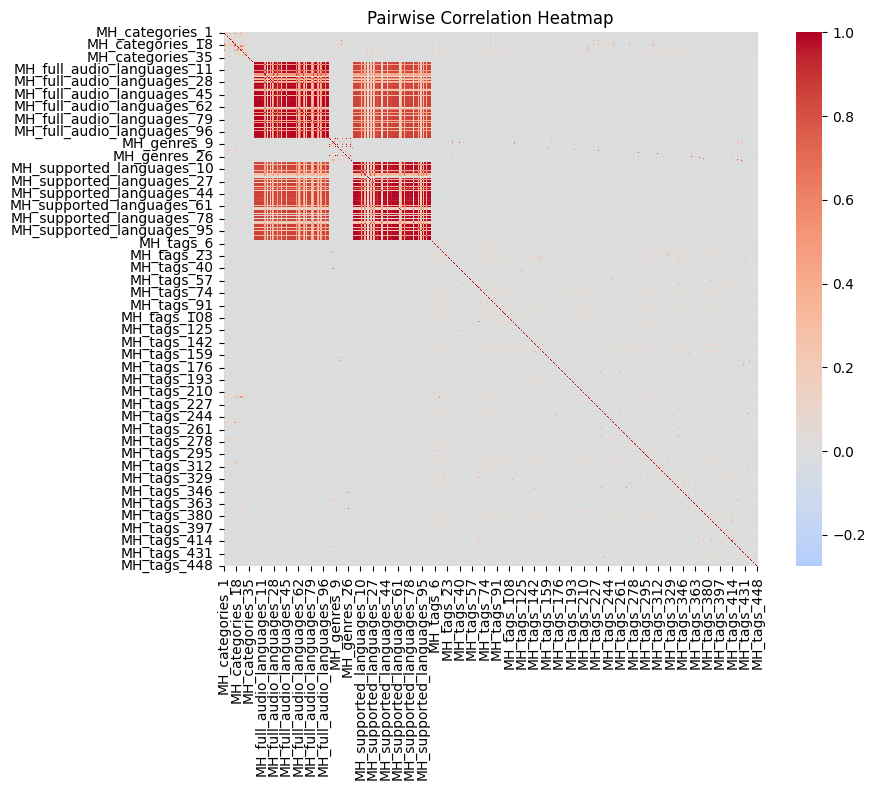

In [34]:
%matplotlib inline
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    square=True,
    center=0,
    linewidths=0
)
plt.title("Pairwise Correlation Heatmap")
plt.tight_layout()
plt.show()

# Dimensionality reduction
There are >700 multi-hot columns, and some of them are highly correlated (the languages). Let's handle that by 
1. TF-IDF to equalize ultra-frequent and ultra-rare labels
2. TruncatedSVD to reduce dimensionality

In [35]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

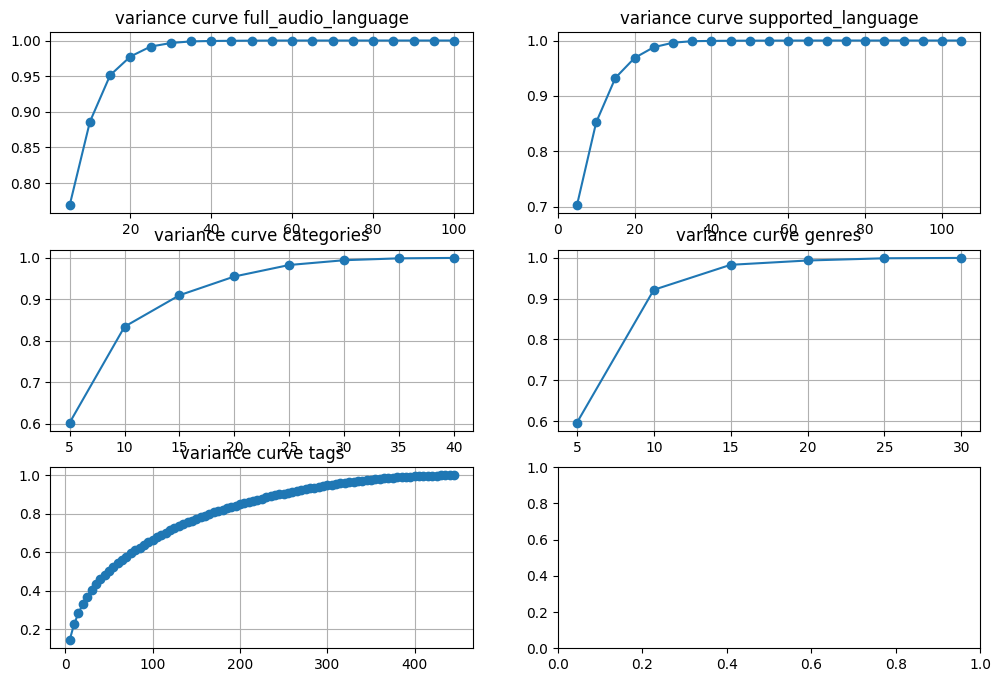

In [36]:
def svd_variance_curve(X, k_max=200, step=5, random_state=0):
    ks = []
    cumvars = []

    for k in range(step, k_max + 1, step):
        svd = TruncatedSVD(n_components=k, random_state=random_state)
        svd.fit(X)
        ks.append(k)
        cumvars.append(svd.explained_variance_ratio_.sum())

    return np.array(ks), np.array(cumvars)


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()

# X_tfidf: TF-IDF matrix (norm=None), sparse
X_tfidf = TfidfTransformer().fit_transform(df_MH_full_audio_languages)
ks, cumvars = svd_variance_curve(X_tfidf, k_max=X_tfidf.shape[1], step=5)
axes[0].plot(ks, cumvars, marker='o')
axes[0].set_title("variance curve full_audio_language")
axes[0].grid(True)

X_tfidf = TfidfTransformer().fit_transform(df_MH_supported_languages)
ks, cumvars = svd_variance_curve(X_tfidf, k_max=X_tfidf.shape[1], step=5)
axes[1].plot(ks, cumvars, marker='o')
axes[1].set_title("variance curve supported_language")
axes[1].grid(True)

X_tfidf = TfidfTransformer().fit_transform(df_MH_categories)
ks, cumvars = svd_variance_curve(X_tfidf, k_max=X_tfidf.shape[1], step=5)
axes[2].plot(ks, cumvars, marker='o')
axes[2].set_title("variance curve categories")
axes[2].grid(True)

X_tfidf = TfidfTransformer().fit_transform(df_MH_genres)
ks, cumvars = svd_variance_curve(X_tfidf, k_max=X_tfidf.shape[1], step=5)
axes[3].plot(ks, cumvars, marker='o')
axes[3].set_title("variance curve genres")
axes[3].grid(True)

X_tfidf = TfidfTransformer().fit_transform(df_MH_tags)
ks, cumvars = svd_variance_curve(X_tfidf, k_max=X_tfidf.shape[1], step=5)
axes[4].plot(ks, cumvars, marker='o')
axes[4].set_title("variance curve tags")
axes[4].grid(True)


plt.show()

Based on the variance curves above, let's keep 
1. 10 components each for full_audio_languages, supported_languages, categories, and genres
2. and 50 components for tags

In [37]:
X_tfidf = TfidfTransformer().fit_transform(df_MH_full_audio_languages)
dense_SVD = TruncatedSVD(n_components=10, random_state=42).fit_transform(X_tfidf)
columns = [f"SVD_full_audio_languages_{i+1}" for i in range(dense_SVD.shape[1])]
df_SVD_full_audio_languages = pd.DataFrame(dense_SVD, columns=columns)

X_tfidf = TfidfTransformer().fit_transform(df_MH_supported_languages)
dense_SVD = TruncatedSVD(n_components=10, random_state=42).fit_transform(X_tfidf)
columns = [f"SVD_supported_languages_{i+1}" for i in range(dense_SVD.shape[1])]
df_SVD_supported_languages = pd.DataFrame(dense_SVD, columns=columns)

X_tfidf = TfidfTransformer().fit_transform(df_MH_categories)
dense_SVD = TruncatedSVD(n_components=10, random_state=42).fit_transform(X_tfidf)
columns = [f"SVD_categories_{i+1}" for i in range(dense_SVD.shape[1])]
df_SVD_categories = pd.DataFrame(dense_SVD, columns=columns)

X_tfidf = TfidfTransformer().fit_transform(df_MH_genres)
dense_SVD = TruncatedSVD(n_components=10, random_state=42).fit_transform(X_tfidf)
columns = [f"SVD_genres_{i+1}" for i in range(dense_SVD.shape[1])]
df_SVD_genres = pd.DataFrame(dense_SVD, columns=columns)

X_tfidf = TfidfTransformer().fit_transform(df_MH_tags)
dense_SVD = TruncatedSVD(n_components=50, random_state=42).fit_transform(X_tfidf)
columns = [f"SVD_tags_{i+1}" for i in range(dense_SVD.shape[1])]
df_SVD_tags = pd.DataFrame(dense_SVD, columns=columns)

df_X_SVD = pd.concat([df_SVD_categories,df_SVD_full_audio_languages,df_SVD_genres,df_SVD_supported_languages,df_SVD_tags],axis=1)

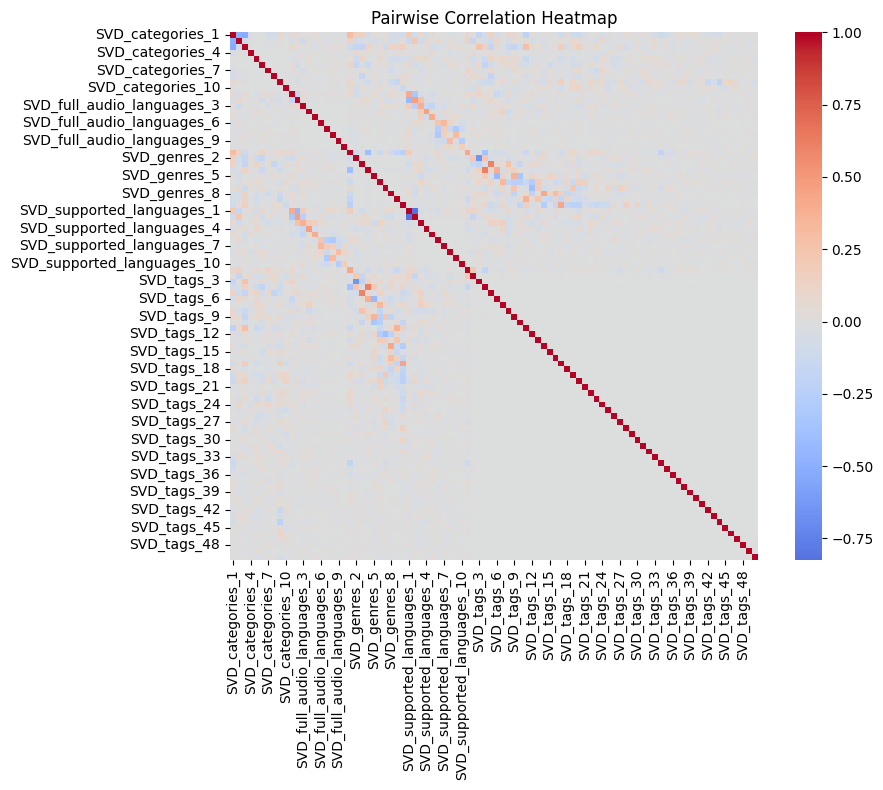

In [38]:
corr_SVD = df_X_SVD.corr()

%matplotlib inline
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_SVD,
    cmap="coolwarm",
    square=True,
    center=0,
    linewidths=0
)
plt.title("Pairwise Correlation Heatmap")
plt.tight_layout()
plt.show()

# Assemble all features
1. Numeric: `df_X_num`
2. Date: `df["release_date"]`
3. Multi-categorical: `df_X_SVD`
4. Boolean: `df[["linux","mac","windows"]]`
5. Other: `df_X_info_avail`

In [39]:
df_X = pd.concat([df_X_num, df["release_date"], df_X_SVD, df[["linux","mac","windows"]],df_X_info_avail],axis=1)

# Save y
We want to predict two things
1. whether the game received a Metacritic score
2. the score, if there is one

In [40]:
df_y = pd.DataFrame({
    "has_score": df["metacritic_url"].notna(),
    "score": df["metacritic_score"].where(df["metacritic_score"]>0)
})
# df_y.to_parquet('./../data/df_y_v1.parquet',compression='gzip')

# Scale X and y
Some of the X contain extremely large values. Z-score them to have better performance.

In [41]:
import pandas as pd
import numpy as np
df_X = pd.read_parquet('./../data/df_X_v1.parquet')
df_y = pd.read_parquet('./../data/df_y_v1.parquet')

In [42]:
from sklearn.preprocessing import StandardScaler

def find_two_unique_cols(df: pd.DataFrame, max_unique=2):
    two_unique = []
    for col in df.columns:
        s = df[col].dropna()
        # Skip empty columns
        if s.empty:
            continue
        # Count unique values (including strings)
        if s.nunique(dropna=True) <= max_unique:
            two_unique.append(col)
    return two_unique

binary_cols = find_two_unique_cols(df_X)
continuous_cols = [c for c in df_X.columns if c not in binary_cols]

SS_X = StandardScaler()
df_X_z = df_X.copy()
df_X_z[continuous_cols] = SS_X.fit_transform(df_X[continuous_cols])
SS_y = StandardScaler()
df_y_z = df_y.copy()
df_y_z["score"] = SS_y.fit_transform(df_y["score"].to_frame()).ravel()

In [43]:
# df_X.to_parquet('./../data/df_X_v1.parquet',compression='gzip')
# df_X_z.to_parquet('./../data/df_X_z_v1.parquet',compression='gzip')
# df_y.to_parquet('./../data/df_y_v1.parquet',compression='gzip')
# df_y_z.to_parquet('./../data/df_y_z_v1.parquet',compression='gzip')
import pickle
data = {
    "SS_X": SS_X,
    "SS_y": SS_y,
    "continuous_cols": continuous_cols,
}

# with open('./../models/StandardScalers.pkl', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(data, f)